# Exploration notebook

Using `multiview-stitcher` to stitch OME-Zarr HCS data.

In [1]:
from pathlib import Path
from fractal_tasks_core.ngff import load_NgffImageMeta

# input_path = Path('/Users/malbert/projects/nrepina/20231129_stitching_forMarvin/fractal_output/100pix/231129NAR.zarr')
input_path = Path('/Users/malbert/projects/nrepina/20240225_shape_remapped_slide4_small/fractal_output/20240225_shape_small_output/240225shape_mip.zarr')

well_path = "A/01/0"

In [2]:
from fractal_tasks_core.channels import get_omero_channel_list
import dask.array as da
from spatial_image import to_spatial_image

def get_sim_from_multiscales(multiscales_path, resolution):

    ngff_image_meta = load_NgffImageMeta(input_path / well_path)
    axes = ngff_image_meta.axes_names
    spatial_dims = [dim for dim in axes if dim in ["z", "y", "x"]]
    scales = ngff_image_meta.pixel_sizes_zyx

    channel_names = [oc.label
        for oc in get_omero_channel_list(image_zarr_path=multiscales_path)]
    
    data = da.from_zarr(f"{multiscales_path / Path(str(resolution))}")

    sim = to_spatial_image(
        data,
        dims=axes,
        c_coords=channel_names,
        scale={dim: scales[resolution][idim]
                for idim, dim in enumerate(spatial_dims)},
        translation={dim: 0 for dim in spatial_dims},
    )

    return sim

xim_well = get_sim_from_multiscales(input_path / well_path, 0)

In [3]:
import anndata as ad

fov_roi_table = ad.read_zarr(input_path / Path(well_path) / "tables/FOV_ROI_table").to_df()
fov_roi_table

,x_micrometer,y_micrometer,z_micrometer,len_x_micrometer,len_y_micrometer,len_z_micrometer,x_micrometer_original,y_micrometer_original
FieldIndex,,,,,,,,
FOV_1,1197.599609,0.000000,0.0,216.666672,216.666672,0.6,-7600.700195,18401.000000
FOV_2,1687.166504,1.599609,0.0,216.666672,216.666672,0.6,-7123.000000,18402.599609
FOV_3,1926.633301,82.800781,0.0,216.666672,216.666672,0.6,-6893.799805,18483.800781
FOV_4,925.732910,266.500000,0.0,216.666672,216.666672,0.6,-7860.700195,18667.500000
FOV_5,1828.566406,351.000000,0.0,216.666672,216.666672,0.6,-6981.600098,18752.000000
FOV_6,1378.466309,474.500000,0.0,216.666672,216.666672,0.6,-7431.700195,18875.500000
FOV_7,1828.566406,567.666016,0.0,216.666672,216.666672,0.6,-6981.600098,18958.300781
FOV_8,2391.333008,700.966797,0.0,216.666672,216.666672,0.6,-6429.100098,19091.599609
FOV_9,2662.732910,874.867188,0.0,216.666672,216.666672,0.6,-6157.700195,19265.500000


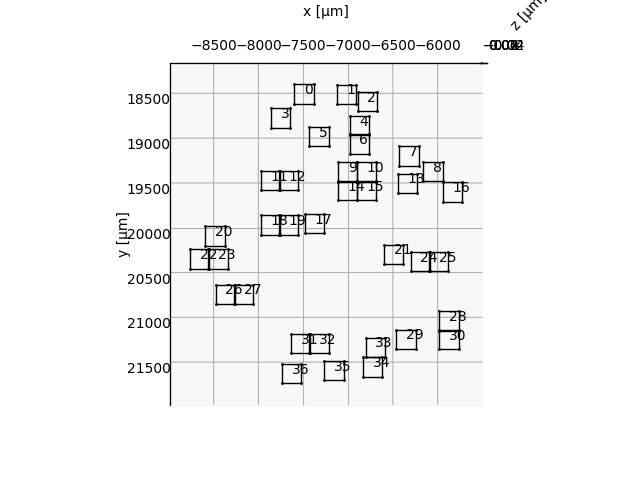

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='z [μm]', ylabel='x [μm]', zlabel='y [μm]'>)

In [4]:
from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import msi_utils, param_utils

input_spatial_dims = [dim for dim in xim_well.dims if dim in ["z", "y", "x"]]
msims = []
for i, row in fov_roi_table.iterrows():

    origin = {dim: row[f'{dim}_micrometer'] for dim in input_spatial_dims}
    extent = {dim: row[f'len_{dim}_micrometer'] for dim in input_spatial_dims}

    origin_original = {dim: row[f'{dim}_micrometer_original'] if dim != 'z' else 0 for dim in input_spatial_dims}
    extent_original = {dim: row[f'len_{dim}_micrometer'] for dim in input_spatial_dims}

    tile = xim_well.sel({dim: slice(origin[dim], origin[dim] + extent[dim])
                         for dim in input_spatial_dims})
    
    tile = tile.squeeze(drop=True)

    tile_spatial_dims = [dim for dim in tile.dims if dim in ["z", "y", "x"]]
        
    sim = si_utils.get_sim_from_array(
        tile.data,
        dims=tile.dims,
        c_coords=xim_well.coords['c'].data,
        scale=si_utils.get_spacing_from_sim(tile),
        translation=origin_original,
        transform_key='fractal_original',
    )

    msim = msi_utils.get_msim_from_sim(
        sim,
        scale_factors=[]
        )

    msims.append(msim)
    
from multiview_stitcher import vis_utils

%matplotlib widget
vis_utils.plot_positions(msims, transform_key='fractal_original', use_positional_colors=False)

[########################################] | 100% Completed | 2.46 ss
[########################################] | 100% Completed | 698.13 ms


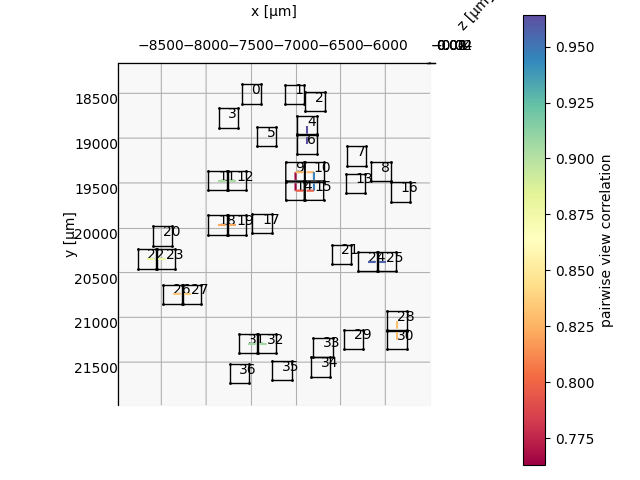

In [6]:
from multiview_stitcher import registration, mv_graph
from dask.diagnostics import ProgressBar

with ProgressBar():
    params = registration.register(
        msims[:],
        transform_key='fractal_original',
        reg_channel_index=1,
        new_transform_key='translation_registered',
        registration_binning={'y': 2, 'x': 2},
        plot_summary=True,
    )

In [7]:
from multiview_stitcher import fusion
import dask.array as da

sims = [msi_utils.get_sim_from_msim(msim) for msim in msims]

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
fused = fusion.fuse(
    sims[:],
    transform_key='translation_registered',
    output_chunksize=xim_well.data.chunksize[-1],
    output_spacing={'y': 0.21666666666666667, 'x': 0.21666666666666667},
    ).sel(t=0, drop=True)

fused

/Users/malbert/mambaforge/envs/fractal_ms/lib/python3.10/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/Users/malbert/mambaforge/envs/fractal_ms/lib/python3.10/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

<xarray.SpatialImage 'image' (c: 2, y: 15401, x: 14042)>
dask.array<getitem, shape=(2, 15401, 14042), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U7 'BCAT488' 'DAPI'
  * y        (y) float64 1.84e+04 1.84e+04 1.84e+04 ... 2.174e+04 2.174e+04
  * x        (x) float64 -8.766e+03 -8.766e+03 ... -5.724e+03 -5.724e+03
Attributes:
    transforms:  {'translation_registered': <xarray.DataArray (x_in: 3, x_out...

In [8]:
# get fused dask array from sim
fused_da = fused.data

In [17]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    fused_da_computed = fused_da.compute()#scheduler='single-threaded')

[                                        ] | 0% Completed | 181.42 us

[########################################] | 100% Completed | 46.73 s


In [26]:
from fractal_tasks_core.pyramids import build_pyramid
build_pyramid?

Signature:
build_pyramid(
    *,
    zarrurl: Union[str, pathlib.Path],
    overwrite: bool = False,
    num_levels: int = 2,
    coarsening_xy: int = 2,
    chunksize: Optional[Sequence[int]] = None,
    aggregation_function: Optional[Callable] = None,
) -> None
Docstring:
Starting from on-disk highest-resolution data, build and write to disk a
pyramid with `(num_levels - 1)` coarsened levels.
This function works for 2D, 3D or 4D arrays.

Args:
    zarrurl: Path of the image zarr group, not including the
        multiscale-level path (e.g. `"some/path/plate.zarr/B/03/0"`).
    overwrite: Whether to overwrite existing pyramid levels.
    num_levels: Total number of pyramid levels (including 0).
    coarsening_xy: Linear coarsening factor between subsequent levels.
    chunksize: Shape of a single chunk.
    aggregation_function: Function to be used when downsampling.
File:      ~/mambaforge/envs/fractal_ms/lib/python3.10/site-packages/fractal_tasks_core/pyramids.py
Type:      function